# Searching for digit manifolds

In this notebook, we'll calculate the level of agreement between elements of a class of digits. The intention is to use the similarity of class elements to sort the elements into a manifold (each successive element appears to be a slight perturbation or continuous deformation of the previous element).

There are 10 classes of digits 0-9. Let $A$ and $B$ be elements of class $N$. For current purposes, the level of agreement between $A$ and $B$ is given by

$$
    \frac{||A\odot B||_F}{\sqrt{||A\odot A||_F}\sqrt{||B\odot B||_F}},
$$
where $\odot$ represents the element-wise Hadamard product, and $||\cdot||_F$ is the Frobenius norm.

I've tried norms of various orders in the above expression for agreement. The norm in both the numerator and denominator should be the same order, since this will give perfect agreement (1.0) for $A = B$. I also tried using the convolution instead of the Hadamard product to allow for translations of $A$ when comparing to $B$. However, the convolution resulted in high agreement between all elements of the sample.

The first few cells of the notebook are just data management and sorting. 

In [38]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn.datasets import fetch_openml
import copy

In [39]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [40]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# Not really necessary, but I'll sort the images by class label.
images.sort_values(by = 'Class label', inplace = True)

# By default, the 'Class label' column is not integer, so we'll convert it here.
images['Class label'] = images['Class label'].apply(int)

# The images are also flattened, so we'll reshape them to (28,28)
images['Image'] = images['Image'].apply(lambda x: x.reshape((28,28)))

In [41]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims = ims.drop('Class label', axis = 1)
    
    return np.array(ims['Image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    for i in range(10):
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(10))))
    return None

In [42]:
data = [extract_image(images, i) for i in range(10)]
display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



In [43]:
# Finally, save each digit separately

zero = data[0]
one = data[1]
two = data[2]
three = data[3]
four = data[4]
five = data[5]
six = data[6]
seven = data[7]
eight = data[8]
nine = data[9]

# Calculating the agreement between classes

We'll take samples from a class and calculate the sample variance. Next, we calculate the agreement within the sample.

In [44]:
# Take N samples from each digit

N = 500

sample0 = zero[:N]
sample1 = one[:N]
sample2 = two[:N]
sample3 = three[:N]
sample4 = four[:N]
sample5 = five[:N]
sample6 = six[:N]
sample7 = seven[:N]
sample8 = eight[:N]
sample9 = nine[:N]

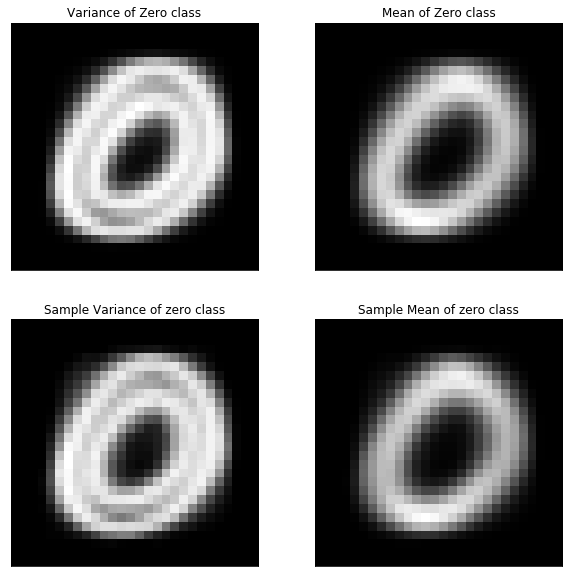

In [45]:
# Variance of the zero digits

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax

ax[0,0].imshow(zero.var(), cmap = 'gray')
ax[0,0].set(title = 'Variance of Zero class', xticks = [], yticks = []);

ax[0,1].imshow(zero.mean(), cmap = 'gray')
ax[0,1].set(title = 'Mean of Zero class', xticks = [], yticks = []);

ax[1,0].imshow(sample0.var(), cmap = 'gray')
ax[1,0].set(title = 'Sample Variance of zero class', xticks = [], yticks = []);

ax[1,1].imshow(sample0.mean(), cmap = 'gray')
ax[1,1].set(title = 'Sample Mean of zero class', xticks = [], yticks = []);

# plt.imshow(zero.var(), cmap = 'gray');

# Finding the families for the zero digit class

The algorithm below calculates the agreement between all elements in a sample of the zero digits. We then sort the elements into 'families', where the 'siblings' in each family are given by agreement over 80%. 

When each family is identified, we take the mean image of each family.

**Note:** When I programmed this, I was using 'chain' instead of 'family'. We'll take that to mean the same thing for now and I'll change it later.

In [46]:
agree = [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for A in sample0 for B in sample0]

In [47]:
agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
agree_chart[agree_chart > 0.99] = 0
agree_chart

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.733372,0.833161,0.583950,0.902934,0.734831,0.657294,0.722485,0.516295,0.765430,...,0.816292,0.782138,0.657063,0.698689,0.708317,0.856218,0.765286,0.778703,0.769961,0.828176
1,0.733372,0.000000,0.859755,0.706382,0.832401,0.851721,0.654487,0.879061,0.829639,0.900750,...,0.831288,0.843591,0.580495,0.834017,0.940601,0.876460,0.853974,0.843759,0.818777,0.906462
2,0.833161,0.859755,0.000000,0.637924,0.911218,0.821698,0.703283,0.805367,0.622057,0.865587,...,0.767570,0.791218,0.611149,0.754858,0.803590,0.834233,0.781952,0.805554,0.768828,0.843317
3,0.583950,0.706382,0.637924,0.000000,0.604394,0.604734,0.663833,0.744473,0.764949,0.730210,...,0.691278,0.812326,0.723327,0.776014,0.640330,0.765400,0.874226,0.691240,0.755228,0.732312
4,0.902934,0.832401,0.911218,0.604394,0.000000,0.803136,0.649695,0.783085,0.561030,0.837318,...,0.780118,0.809760,0.638499,0.727314,0.787171,0.841791,0.792347,0.802423,0.771353,0.852304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.856218,0.876460,0.834233,0.765400,0.841791,0.795855,0.725602,0.870652,0.731702,0.884043,...,0.908774,0.908230,0.697971,0.883239,0.818695,0.000000,0.931959,0.859908,0.899198,0.922732
496,0.765286,0.853974,0.781952,0.874226,0.792347,0.720520,0.693972,0.852461,0.789087,0.847904,...,0.844200,0.940892,0.761359,0.877333,0.803091,0.931959,0.000000,0.801340,0.908130,0.874205
497,0.778703,0.843759,0.805554,0.691240,0.802423,0.822913,0.829596,0.898638,0.638108,0.908156,...,0.937970,0.793021,0.572379,0.793416,0.798424,0.859908,0.801340,0.000000,0.808879,0.882897
498,0.769961,0.818777,0.768828,0.755228,0.771353,0.755198,0.708440,0.804267,0.705831,0.826638,...,0.841589,0.914484,0.794753,0.876975,0.759520,0.899198,0.908130,0.808879,0.000000,0.874366


In [48]:
def get_chains(ag_chart, threshold = 0.8, start_row = 0):
    """ Get the list of chains of digits with high levels of agreement. 
    """
    
    chains = []   
    
    while not ag_chart.empty:
        chain = [start_row]

        ag_chart.drop(start_row, axis = 1, inplace = True)

        while ag_chart.loc[start_row].max() > threshold:
            
            # Find the column that corresponds to the next row to search
            next_row = ag_chart.loc[start_row].idxmax(axis = 0)
            ag_chart.loc[start_row] = 0

            start_row = next_row
            # Drop the column we just searched
            ag_chart.drop(start_row, axis = 1, inplace = True)

            chain.append(start_row)
        
        ag_chart.drop(chain, axis = 0, inplace = True)
        chains.append(chain)
    
        try:
            start_row = ag_chart.index[0]
        except:
            break
            
    return chains

This next cell finds the chains of digits that have agreement of more than 80%.

In [49]:
threshold = 0.8

families = get_chains(agree_chart, threshold = threshold)
# print(families)

In [50]:
def display_chain(chains, sample):
    """ Display the mean digit obtained by averaging over each chain of digits. """
    
    ims = [sum(sample[i] for i in chain)/len(chain) for chain in chains]
    
    print('Algorithm found {} families of digits with threshold {}.'.format(len(chains), threshold))
    
    fig, ax = plt.subplots(1,len(ims),figsize=(12,12))
    
    for i in range(len(ims)):
        ax[i].imshow(ims[i], cmap = 'gray');
        ax[i].set(xticks = [], yticks = []);
    return None

display_chain(families, sample0)

Algorithm found 41 families of digits with threshold 0.8.


In the output above, families with more than one member have their 'family mean' displayed (the mean of all images in the family).

# Finding family means for every digit class

This is working really well for finding chains of similar digits. Now I'll perform the algorithm on each digit class.

In [51]:
samples = [sample0, sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9]

In [52]:
import itertools

def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    agree = [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for A in sample for B in sample]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

def similarity2(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    def sim(cartesian_product):
        """ Take in a tuple and compute the similarity of its elements """
        return [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for (A,B) in cartesian_product]
    
    agree = sim(list(itertools.product(sample, sample)))
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

# THIS STEP IS THE MAJOR SLOWDOWN

In [53]:
# Find the agreement chart for all samples
agreement_charts = [similarity(sample) for sample in samples]

# Get deep copies of the agreement charts to use in future test cases (deep copies ensure new objects are created)
agreement_charts70 = copy.deepcopy(agreement_charts)
agreement_charts80 = copy.deepcopy(agreement_charts)
agreement_charts90 = copy.deepcopy(agreement_charts)

agreement_charts75 = copy.deepcopy(agreement_charts)
agreement_charts60 = copy.deepcopy(agreement_charts)

In [54]:
# Find the chains of similar digits for all digit classes.

all_families = {key:get_chains(ag, threshold = 0.8) for key,ag in zip(range(len(agreement_charts80)), agreement_charts80)}

Algorithm found 41 families of digits with threshold 0.8.
Algorithm found 11 families of digits with threshold 0.8.
Algorithm found 84 families of digits with threshold 0.8.
Algorithm found 75 families of digits with threshold 0.8.
Algorithm found 58 families of digits with threshold 0.8.
Algorithm found 129 families of digits with threshold 0.8.
Algorithm found 47 families of digits with threshold 0.8.
Algorithm found 56 families of digits with threshold 0.8.
Algorithm found 90 families of digits with threshold 0.8.
Algorithm found 46 families of digits with threshold 0.8.


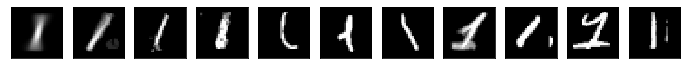

In [55]:
for key, sample in zip(all_families, samples):
    display_chain(all_families[key], sample)

# Computing projections onto the bases - an example with 10 test images

- take some random examples of digits, calculate the agreement with each basis; take largest value as the class

Further ideas:
- reduce the basis size

In [56]:
# Computing similarity of the test digits with the computed digit families - highest agreement indicates the digit class

def project_test_digit(digit, family):
    """ Calculate the projection of 'digit' onto a 'family' of digits. """
    
    coef = [LA.norm(digit*B,'fro')/(np.sqrt(LA.norm(digit*digit,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for B in family]
    
    # Take infinity norm to find the best agreement for each family
    max_agreement = np.max(coef)
    return max_agreement

def mean_digits(family, sample):
    """ Take a family of digits, compute the mean image for long families. """
    
    ims = [sum(sample[i] for i in chain)/len(chain) for chain in family]
    print('{} images computed for family of length {}'.format(len(ims), len(family)))
    
    return ims

In [57]:
bases = {}

# Get the mean image for families with length greater than 1
for key, sample, index in zip(all_families, samples, range(10)):
    bases[index] = mean_digits(all_families[key], sample)

41 images computed for family of length 41
11 images computed for family of length 11
84 images computed for family of length 84
75 images computed for family of length 75
58 images computed for family of length 58
129 images computed for family of length 129
47 images computed for family of length 47
56 images computed for family of length 56
90 images computed for family of length 90
46 images computed for family of length 46


# March 31 2020

# In-family similarity threshold: 80%

Now we take 500 test images and run them through our algorithm. We compute the similarity of each test digit with the bases calculated above. The overall agreement between a test digit and a basis is given by the mean agreement of the test digit and all basis elements of the given basis. 

Let $K$ be the size of a given basis, $\beta_k$ be a basis element, and $T$ be the test digit. The agreement of the test digit with a basis element is given by
$$
    \text{sim}(T, \beta_k) = \frac{||T\odot \beta_k||_F}{\sqrt{||T\odot T||_F}\sqrt{||\beta_k\odot \beta_k||_F}},
$$
as above. 

The overall agreement between the test digit $T$ and the basis $B  = \{ \beta_k \}$ is given by
$$
    \mu(T, B) = \max_{\beta_k}\{ \text{sim}(T, \beta_k) \}.
$$

In [58]:
# Take the last 500 images as test images

N = 500

test_images = {0: zero[-N:],
               1: one[-N:],
               2: two[-N:],
               3: three[-N:],
               4: four[-N:],
               5: five[-N:],
               6: six[-N:],
               7: seven[-N:],
               8: eight[-N:],
               9: nine[-N:]}

In [59]:
""" This calculates the projection of each testing digit onto every basis in 'bases'.
"""

result = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result[key] = [[project_test_digit(digit, bases[j]) for j in range(10)] for digit in test_images[key]]

Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...


In [60]:
# Get the computed labels 
def get_all_labels(result):
    """ Take in a dictionary of projections for each digit class, predict the class. """
    
    # Pair the predicted class with the correct class
    predictions = {}
    
    for key in result:
        # 'key' is the correct class, 'np.argmax(proj)' is the predicted class
        predictions[key] = [np.argmax(proj) for proj in result[key]] 
            
    return predictions

In [61]:
pred = get_all_labels(result)

In [62]:
def calc_accuracy(predictions):
    """ From a dictionary of predicted class labels, compute the mis-classification ratio. 
    
        Input:
        ------
        predictions := a dictionary containing {class: predicted_class_labels}
        
        Output:
        -------
        1 - error_rate := gives the overall accuracy of the method
    """
    
    N = 500
    
    length = N*10
    wrong = 0
    
    wrong_per_class = []
    
    for correct_label in predictions:
        # Make an array of correct class labels
        temp_correct_list = np.array([correct_label]*N)
        
        # Make an array of 0 where the correct label was computed, 1 otherwise
        amt_wrong = np.where(np.abs(temp_correct_list - predictions[correct_label]) > 0, 1, 0)
        
        wrong_per_class.append(amt_wrong.sum())
        
        wrong += amt_wrong.sum()
        print('Accuracy for class {}: {:.1f}%'.format(correct_label, 100*(1 - amt_wrong.sum()/len(temp_correct_list))))
    
    error_rate = wrong/length
    return 1 - error_rate

In [63]:
print('Overall prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

Accuracy for class 0: 94.0%
Accuracy for class 1: 81.2%
Accuracy for class 2: 89.4%
Accuracy for class 3: 81.4%
Accuracy for class 4: 84.4%
Accuracy for class 5: 85.2%
Accuracy for class 6: 95.8%
Accuracy for class 7: 90.2%
Accuracy for class 8: 86.4%
Accuracy for class 9: 78.0%
Overall prediction accuracy: 86.6000%


# Using a lower threshold

This is the same experiment, but with the threshold for digit families in a basis set to 70%.

Algorithm found 11 families of digits with threshold 0.7.
Algorithm found 6 families of digits with threshold 0.7.
Algorithm found 21 families of digits with threshold 0.7.
Algorithm found 22 families of digits with threshold 0.7.
Algorithm found 18 families of digits with threshold 0.7.
Algorithm found 38 families of digits with threshold 0.7.
Algorithm found 12 families of digits with threshold 0.7.
Algorithm found 15 families of digits with threshold 0.7.
Algorithm found 21 families of digits with threshold 0.7.
Algorithm found 9 families of digits with threshold 0.7.


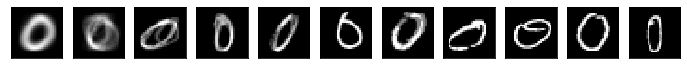

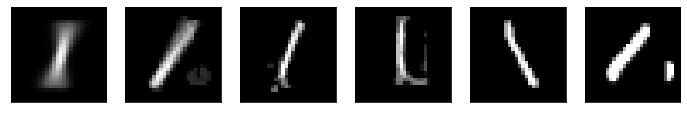

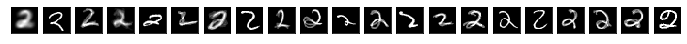

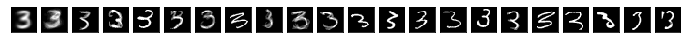

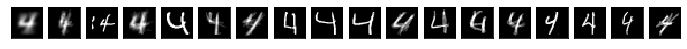

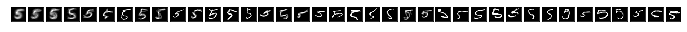

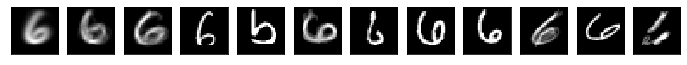

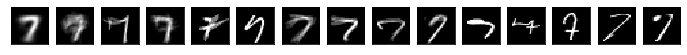

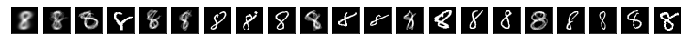

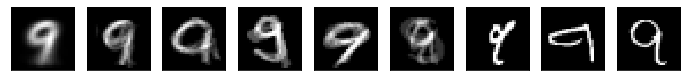

In [64]:
threshold = 0.7

# agreement_charts = [similarity(sample) for sample in samples]
all_families = {key:get_chains(ag, threshold = threshold) for key,ag in zip(range(len(agreement_charts70)), agreement_charts70)}

for key, sample in zip(all_families, samples):
    display_chain(all_families[key], sample)

In [65]:
bases = {}

# Get the mean image for families with length greater than 1
for key, sample, index in zip(all_families, samples, range(10)):
    bases[index] = mean_digits(all_families[key], sample)

11 images computed for family of length 11
6 images computed for family of length 6
21 images computed for family of length 21
22 images computed for family of length 22
18 images computed for family of length 18
38 images computed for family of length 38
12 images computed for family of length 12
15 images computed for family of length 15
21 images computed for family of length 21
9 images computed for family of length 9


In [66]:
""" This calculates the projection of each testing digit onto every basis in 'bases'.
"""

result = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result[key] = [[project_test_digit(digit, bases[j]) for j in range(10)] for digit in test_images[key]]
    
pred = get_all_labels(result)
print('Prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...
Accuracy for class 0: 80.6%
Accuracy for class 1: 91.8%
Accuracy for class 2: 75.2%
Accuracy for class 3: 84.4%
Accuracy for class 4: 83.4%
Accuracy for class 5: 76.6%
Accuracy for class 6: 89.2%
Accuracy for class 7: 84.0%
Accuracy for class 8: 74.6%
Accuracy for class 9: 65.4%
Prediction accuracy: 80.5200%


# Using a higher threshold

Now we do the same experiment as above, but we increase the similarity threshold for bases to 90%.

In [67]:
threshold = 0.9

all_families = {key:get_chains(ag, threshold = threshold) for key,ag in zip(range(len(agreement_charts90)), agreement_charts90)}

for key, sample in zip(all_families, samples):
    display_chain(all_families[key], sample)

Algorithm found 201 families of digits with threshold 0.9.
Algorithm found 45 families of digits with threshold 0.9.
Algorithm found 386 families of digits with threshold 0.9.
Algorithm found 342 families of digits with threshold 0.9.
Algorithm found 328 families of digits with threshold 0.9.
Algorithm found 420 families of digits with threshold 0.9.
Algorithm found 252 families of digits with threshold 0.9.
Algorithm found 250 families of digits with threshold 0.9.
Algorithm found 366 families of digits with threshold 0.9.
Algorithm found 223 families of digits with threshold 0.9.


In [68]:
bases = {}

# Get the mean image for families with length greater than 1
for key, sample, index in zip(all_families, samples, range(10)):
    bases[index] = mean_digits(all_families[key], sample)

201 images computed for family of length 201
45 images computed for family of length 45
386 images computed for family of length 386
342 images computed for family of length 342
328 images computed for family of length 328
420 images computed for family of length 420
252 images computed for family of length 252
250 images computed for family of length 250
366 images computed for family of length 366
223 images computed for family of length 223


In [69]:
""" This calculates the projection of each testing digit onto every basis in 'bases'.
"""

result = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result[key] = [[project_test_digit(digit, bases[j]) for j in range(10)] for digit in test_images[key]]
    
pred = get_all_labels(result)
print('Prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...
Accuracy for class 0: 99.0%
Accuracy for class 1: 97.0%
Accuracy for class 2: 92.4%
Accuracy for class 3: 94.2%
Accuracy for class 4: 92.0%
Accuracy for class 5: 86.6%
Accuracy for class 6: 96.8%
Accuracy for class 7: 93.2%
Accuracy for class 8: 86.2%
Accuracy for class 9: 87.6%
Prediction accuracy: 92.5000%


# Comparing the above technique with using the mean of the basis digits

The accuracy of the first method above was about 34%. The accuracy for the second method (with 'family agreement' of 90%) was about 27%. Can we get a higher accuracy by simply using the mean of the training sets?

In [70]:
bases = {label: sample.mean() for label, sample in zip(range(10), samples)}

def project_onto_mean(digit, mean_image):
    """ Calculate the projection of 'digit' onto a 'family' of digits. """
    
    coef = LA.norm(digit*mean_image,'fro')/(np.sqrt(LA.norm(digit*digit,'fro'))*np.sqrt(LA.norm(mean_image*mean_image,'fro')))
    
    return coef

In [71]:
result = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result[key] = [[project_onto_mean(digit, bases[j]) for j in range(10)] for digit in test_images[key]]
    
pred = get_all_labels(result)
print('Prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...
Accuracy for class 0: 87.2%
Accuracy for class 1: 86.2%
Accuracy for class 2: 74.0%
Accuracy for class 3: 80.4%
Accuracy for class 4: 81.4%
Accuracy for class 5: 52.2%
Accuracy for class 6: 86.4%
Accuracy for class 7: 82.2%
Accuracy for class 8: 71.4%
Accuracy for class 9: 69.8%
Prediction accuracy: 77.1200%


# Comparing with using the variance of basis digits

In [72]:
bases = {label: sample.var() for label, sample in zip(range(10), samples)}

result = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result[key] = [[project_onto_mean(digit, bases[j]) for j in range(10)] for digit in test_images[key]]
    
pred = get_all_labels(result)
print('Prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...
Accuracy for class 0: 77.4%
Accuracy for class 1: 81.0%
Accuracy for class 2: 72.4%
Accuracy for class 3: 62.0%
Accuracy for class 4: 51.4%
Accuracy for class 5: 64.4%
Accuracy for class 6: 74.8%
Accuracy for class 7: 79.8%
Accuracy for class 8: 35.2%
Accuracy for class 9: 34.6%
Prediction accuracy: 63.3000%


- Test training sets against bases to see if mean of siblings is getting high agreement

In [73]:
test_images = {0: sample0,
               1: sample1,
               2: sample2,
               3: sample3,
               4: sample4,
               5: sample5,
               6: sample6,
               7: sample7,
               8: sample8,
               9: sample9}

In [74]:
threshold = 0.8

all_families = {key:get_chains(ag, threshold = threshold) for key,ag in zip(range(len(agreement_charts75)), agreement_charts75)}

bases = {}

# Get the mean image for families with length greater than 1
for key, sample, index in zip(all_families, samples, range(10)):
    bases[index] = mean_digits(all_families[key], sample)

result75 = {}

for key in test_images:
    print('Computing projections for class {}...'.format(key))
    result75[key] = [[project_test_digit(digit, bases[j]) for j in range(10)] for digit in test_images[key]]
    
pred = get_all_labels(result75)
print('Prediction accuracy: {:.4f}%'.format(100*calc_accuracy(pred)))

41 images computed for family of length 41
11 images computed for family of length 11
84 images computed for family of length 84
75 images computed for family of length 75
58 images computed for family of length 58
129 images computed for family of length 129
47 images computed for family of length 47
56 images computed for family of length 56
90 images computed for family of length 90
46 images computed for family of length 46
Computing projections for class 0...
Computing projections for class 1...
Computing projections for class 2...
Computing projections for class 3...
Computing projections for class 4...
Computing projections for class 5...
Computing projections for class 6...
Computing projections for class 7...
Computing projections for class 8...
Computing projections for class 9...
Accuracy for class 0: 93.8%
Accuracy for class 1: 85.4%
Accuracy for class 2: 96.8%
Accuracy for class 3: 88.8%
Accuracy for class 4: 88.0%
Accuracy for class 5: 95.4%
Accuracy for class 6: 96.0%
Ac